# Imports

In [1]:
import warnings
warnings.simplefilter(action="ignore")

import datetime as dt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Data Preparation

In [2]:
df = pd.read_csv("onlineretail.csv")

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.shape

(541909, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
# Drop duplicates
df.drop_duplicates(inplace=True)

In [7]:
# Drop all rows where customerId is null
df = df[~df["CustomerID"].isnull()]

In [8]:
# Drop records where Quantity or UnitPrice is zero
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [9]:
# Create a total price column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Exploratory Data Analysis

In [10]:
# Top Countries by Number of Customers
top_countries = df.groupby('Country')['CustomerID'].nunique().sort_values(ascending=False)[:10]
top_countries

Country
United Kingdom    3920
Germany             94
France              87
Spain               30
Belgium             25
Switzerland         21
Portugal            19
Italy               14
Finland             12
Austria             11
Name: CustomerID, dtype: int64

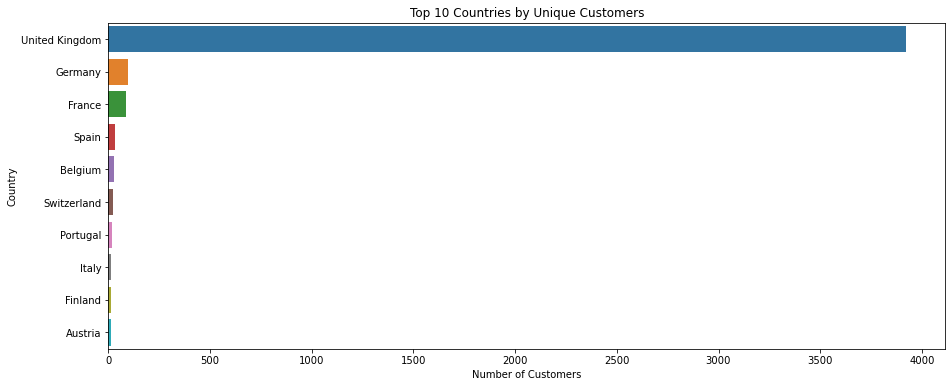

In [11]:
# Visualise Top Countries by Number of Customers using horizontal barplot
plt.subplots(figsize=(15,6))
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title("Top 10 Countries by Unique Customers")
plt.xlabel("Number of Customers")
for i,v in enumerate(top_countries.values):
    pass
plt.show()

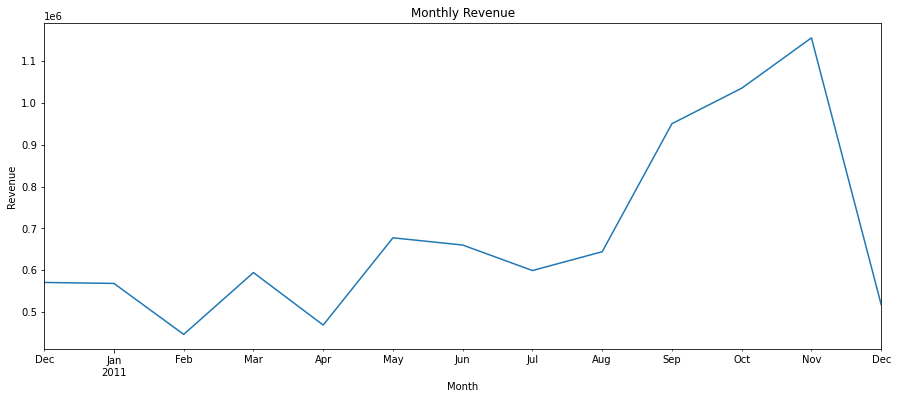

In [12]:
# Monthly Sales Trend
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
monthly_sales = df.groupby('InvoiceMonth')['TotalPrice'].sum()
plt.subplots(figsize=(15,6))
monthly_sales.plot(kind='line', title='Monthly Revenue')
plt.ylabel('Revenue')
plt.xlabel('Month')
plt.show()

In [13]:
# Top 10 Best-Selling Products

top_products = df.groupby(df["Description"])["Quantity"].sum().sort_values(ascending=False).head(10)
top_products

Description
PAPER CRAFT , LITTLE BIRDIE           80995
MEDIUM CERAMIC TOP STORAGE JAR        77916
WORLD WAR 2 GLIDERS ASSTD DESIGNS     54319
JUMBO BAG RED RETROSPOT               46078
WHITE HANGING HEART T-LIGHT HOLDER    36706
ASSORTED COLOUR BIRD ORNAMENT         35263
PACK OF 72 RETROSPOT CAKE CASES       33670
POPCORN HOLDER                        30919
RABBIT NIGHT LIGHT                    27153
MINI PAINT SET VINTAGE                26076
Name: Quantity, dtype: int64

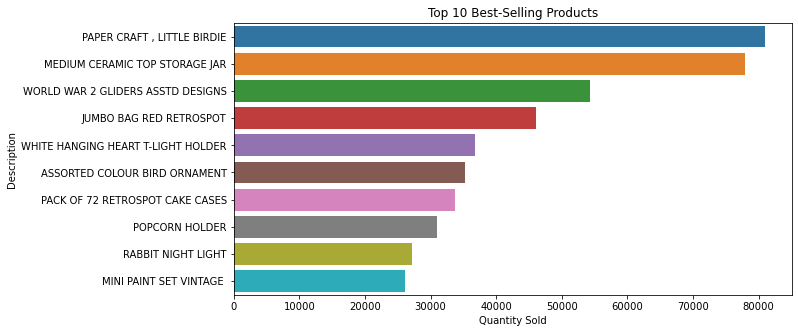

In [14]:
plt.figure(figsize=(10,5))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title("Top 10 Best-Selling Products")
plt.xlabel("Quantity Sold")
plt.show()

In [15]:
df.describe()

,Quantity,UnitPrice,CustomerID,TotalPrice
count,392692.000000,392692.000000,392692.000000,392692.000000
mean,13.119702,3.125914,15287.843865,22.631500
std,180.492832,22.241836,1713.539549,311.099224
min,1.000000,0.001000,12346.000000,0.001000
25%,2.000000,1.250000,13955.000000,4.950000
50%,6.000000,1.950000,15150.000000,12.450000
75%,12.000000,3.750000,16791.000000,19.800000
max,80995.000000,8142.750000,18287.000000,168469.600000


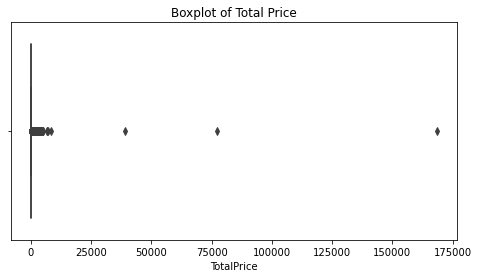

In [16]:
# Check for outliers in total price
plt.figure(figsize=(8, 4))
sns.boxplot(x=df["TotalPrice"])
plt.title("Boxplot of Total Price")
plt.xlabel("TotalPrice")
plt.show()

In [17]:
# Remove outliers
lower_bound = df['TotalPrice'].quantile(0.05)  # 5th percentile
upper_bound = df['TotalPrice'].quantile(0.95)  # 95th percentile
df = df[df["TotalPrice"].between(lower_bound, upper_bound)]
df.describe()

,Quantity,UnitPrice,CustomerID,TotalPrice
count,358713.000000,358713.000000,358713.000000,358713.000000
mean,8.767290,2.918668,15282.234906,13.914561
std,12.559421,3.135524,1712.142641,11.558049
min,1.000000,0.040000,12347.000000,1.250000
25%,2.000000,1.250000,13934.000000,5.000000
50%,6.000000,1.950000,15150.000000,11.800000
75%,12.000000,3.750000,16788.000000,17.700000
max,900.000000,65.000000,18287.000000,67.500000


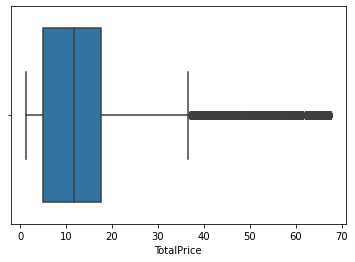

In [18]:
# Check the distribution of UnitPrice
sns.boxplot(x=df["TotalPrice"]);

In [19]:
# Create Frequency, Recency and Monetary tables
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12347.0,2,7,3516.98
12348.0,75,4,803.24
12349.0,19,1,1457.55
12350.0,310,1,334.40
12352.0,36,7,1505.74


In [20]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4223 entries, 12347.0 to 18287.0
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    4223 non-null   int64  
 1   Frequency  4223 non-null   int64  
 2   Monetary   4223 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 132.0 KB


# Scaling



In [21]:
# Standardize so all features be on same scale
ss = StandardScaler()
scaled_data = ss.fit_transform(rfm)
scaled_data_df = pd.DataFrame(scaled_data)
scaled_data_df.columns = rfm.columns
scaled_data_df.head()

,Recency,Frequency,Monetary
0,-0.906868,0.407580,0.899309
1,-0.174028,-0.010088,-0.145851
2,-0.736207,-0.427756,0.106147
3,2.185117,-0.427756,-0.326419
4,-0.565545,0.407580,0.124707


In [22]:
# Check if data is scaled
scaled_data_df.aggregate(["mean", "std"]).astype(int)

,Recency,Frequency,Monetary
mean,0,0,0
std,1,1,1


# Model Building


In [23]:
# using number of estimators to be 1 to 10, calculate inertia and use elbow method to find the best points 

inertials = []
silhouette_scores = []

for k in range(2, 11):
    model = make_pipeline(StandardScaler(), KMeans(n_clusters=k, random_state=42))
    model.fit(rfm)
    
    kmeans_model = model.named_steps["kmeans"]
    
    inertials.append(kmeans_model.inertia_)
    silhouette_scores.append(silhouette_score(rfm, kmeans_model.labels_))

print("Inertias:", inertials)
print("Silhouette Scores:", silhouette_scores)

Inertias: [9003.560671284795, 5648.261686398681, 3831.640140563025, 2923.7776557430398, 2398.664038753625, 1979.228710245327, 1669.472412244505, 1442.9939006457637, 1244.596311046805]
Silhouette Scores: [-0.08385623263268428, -0.06670865233410493, 0.022332759835293352, 0.033529073696674724, 0.12452048462032639, 0.04822854512749323, 0.05537459505500067, 0.05405239413017087, 0.10793979761741662]


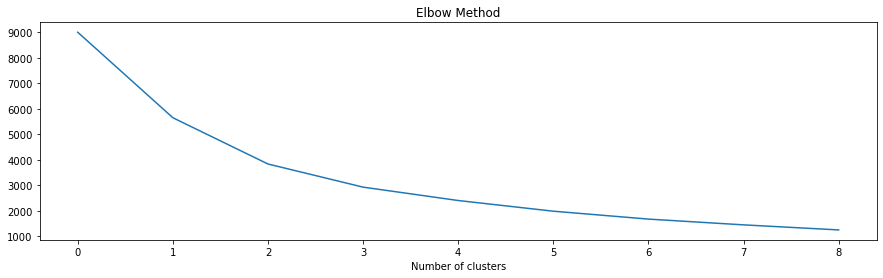

In [24]:
plt.subplots(figsize=(15, 4))
plt.plot(inertials)
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.show()

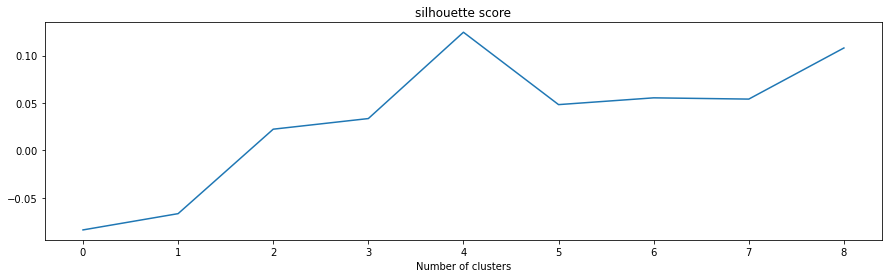

In [25]:
# Use silhouette_score to determine the best number of clusters
plt.subplots(figsize=(15, 4))
plt.plot(silhouette_scores)
plt.title("silhouette score")
plt.xlabel("Number of clusters")
plt.show()


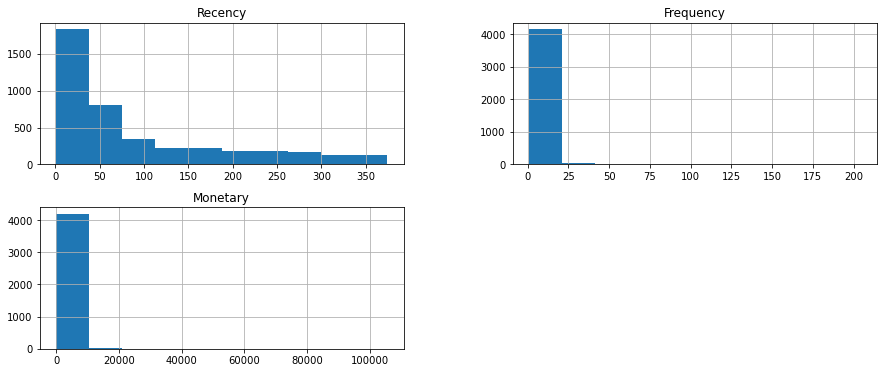

In [26]:
# bad silhouette scores might be due to outliers 

rfm.hist( figsize=(15, 6));

In [27]:
rfm.describe()

,Recency,Frequency,Monetary
count,4223.000000,4223.000000,4223.000000
mean,92.335307,4.072460,1181.940341
std,99.624179,7.183588,2596.788165
min,1.000000,1.000000,1.900000
25%,18.000000,1.000000,245.955000
50%,51.000000,2.000000,549.840000
75%,143.000000,4.000000,1335.625000
max,374.000000,204.000000,105586.210000


In [28]:
# Remove from all Recency 85th percentile
rfm = rfm[
    (rfm["Recency"] <= rfm["Recency"].quantile([0.85]).values[0]) &
    (rfm["Frequency"] <= rfm["Frequency"].quantile([0.85]).values[0]) &
    (rfm["Monetary"] <= rfm["Monetary"].quantile([0.85]).values[0])

]
rfm.shape


(2830, 3)

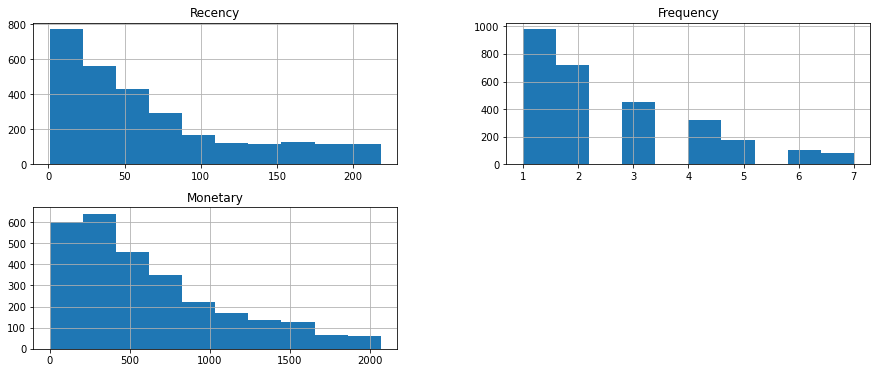

In [29]:
rfm.hist( figsize=(15, 6));

In [30]:
rfm.shape

(2830, 3)

In [31]:
inertials = []
silhouette_scores = []

for k in range(2, 11):
    model = make_pipeline(StandardScaler(), KMeans(n_clusters=k, random_state=42))
    model.fit(rfm)
    
    kmeans_model = model.named_steps["kmeans"]
    
    inertials.append(kmeans_model.inertia_)
    silhouette_scores.append(silhouette_score(rfm, kmeans_model.labels_))

print("Inertias:", inertials)
print("Silhouette Scores:", silhouette_scores)

Inertias: [4809.561675681838, 3092.3764788076346, 2485.6952608118345, 2177.713456031991, 1940.8001932219513, 1734.9099873561322, 1558.2391692638885, 1446.1953255164622, 1339.289200339103]
Silhouette Scores: [0.5036634646210177, 0.1828854755179452, 0.17508917006813848, 0.10715116267249926, 0.05481087461724917, 0.055173108917625766, 0.004411449031491265, -0.02789526380667321, -0.0092755065716822]


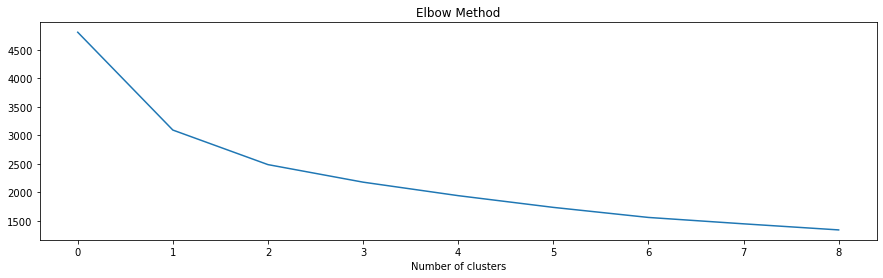

In [32]:
plt.subplots(figsize=(15, 4))
plt.plot(inertials)
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.show()

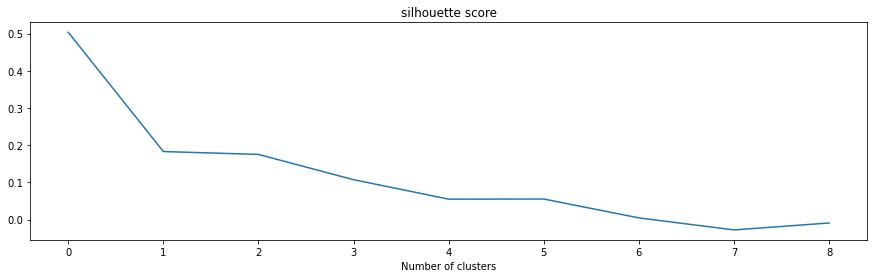

In [33]:
# Use silhouette_score to determine the best number of clusters
plt.subplots(figsize=(15, 4))
plt.plot(silhouette_scores)
plt.title("silhouette score")
plt.xlabel("Number of clusters")
plt.show()


In [34]:
# Build final model using k = 2
final_model = make_pipeline(StandardScaler(), KMeans(n_clusters=2, random_state=42))

# Fit model to data
final_model.fit(rfm)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=2, random_state=42))])

# Communicate Result

In [37]:
rfm["cluster"] = final_model["kmeans"].labels_

In [38]:
rfm.head()

,Recency,Frequency,Monetary,cluster
CustomerID,,,,
12348.0,75,4,803.24,1
12349.0,19,1,1457.55,1
12352.0,36,7,1505.74,1
12353.0,204,1,89.00,0
12355.0,214,1,264.40,0
